Setting

In [1]:
import os
import sys

import torch
import mlflow
import seaborn as sns

FIGURE_DIR = os.getcwd()
MIL_DIR = os.path.dirname(FIGURE_DIR)
NB_DIR = os.path.dirname(MIL_DIR)
ROOT_DIR = os.path.dirname(NB_DIR)
EXP_DIR = os.path.join(ROOT_DIR, "experiments")
sys.path.append(ROOT_DIR)

from mlflow_settings import TRACKING_URI

from experiments.MIL.exps.run_train_baseline import select_sample_dataset

mlflow.set_tracking_uri(TRACKING_URI)
DEVICE = "cuda:2"

In [2]:
from sklearn.model_selection import StratifiedKFold
from utils.serialization_ops import load_pickle
from setting import DATASET_PATH, FOLD

dataset = load_pickle(DATASET_PATH)
with open(os.path.join(EXP_DIR, "external_test_snv_sample_ids.txt")) as fh:
    external_snv_sample_ids = [line.strip() for line in fh.readlines()]
with open(os.path.join(EXP_DIR, "external_test_cnv_sample_ids.txt")) as fh:
    external_cnv_sample_ids = [line.strip() for line in fh.readlines()]

ext_snv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_snv_sample_ids, dataset
)
ext_cnv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_cnv_sample_ids, train_val_test_dataset
)

my_fold = FOLD
stratified_kfold = StratifiedKFold(5, random_state=20230524, shuffle=True)
stratified_kflod_iter = stratified_kfold.split(train_val_test_dataset, train_val_test_dataset.bag_labels)
for fold, (train_val, test_indice) in enumerate(stratified_kflod_iter, start=1):
    if fold == my_fold:
        break

In [3]:
import torch
from setting import MODEL_PATH, SCALER_PATH, additional_features
from core.evaluation import MILModelEvaluator
from core.datasets import ExSCNVDataset
mlflow.set_tracking_uri(TRACKING_URI)
model = mlflow.pytorch.load_model(MODEL_PATH).to("cuda")
scaler_path = mlflow.artifacts.download_artifacts(SCALER_PATH)
scalers = torch.load(scaler_path, map_location="cuda")["scaler"]

evaluator = MILModelEvaluator(model)

test_dataset = ExSCNVDataset(
    train_val_test_dataset[test_indice],
    base_features=[
        "ACMG_bayesian",
        "symptom_similarity",
        "vcf_info_QUAL",
        "inhouse_freq",
        "vaf",
        "is_incomplete_zygosity",
    ],
    additional_features=additional_features,
    scalers=scalers,
    device="cuda",
)

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, model) -> None:
        super().__init__()
        self.snv_encoder = model.encoder_snv
        self.cnv_encoder = model.encoder_cnv
        self.projector = model.encoded_vec_projection

    def forward(self, x):
        snv, cnv = x
        feat_snv = self.snv_encoder(snv)
        feat_cnv = self.cnv_encoder(cnv)

        return self.projector(torch.concat([feat_snv, feat_cnv]))

encoder = Encoder(model)
_ = encoder.eval()

In [5]:
snv_cnv_confirmed_samples = [
    patient_data
    for patient_data in test_dataset.patient_datasets
    if patient_data.snv_data.y.sum() >= 1 and patient_data.cnv_data.y.sum() >= 1
]
print(len(snv_cnv_confirmed_samples))

5


In [12]:
import random
from sklearn.manifold import TSNE

patient_data = random.sample(snv_cnv_confirmed_samples, k=1)[0]
print(patient_data)
print(patient_data.snv_data, patient_data.cnv_data)

sample_idx = [
    patient_data.sample_id
    for patient_data in test_dataset.patient_datasets
].index(patient_data.sample_id)

with torch.no_grad():
    (snv, cnv), instance_label, bag_label = test_dataset[sample_idx]
    feature = encoder((snv, cnv)).cpu().numpy()

tsne = TSNE(n_components=2, random_state=2)
snv_cnv_embedded = tsne.fit_transform(feature)

PatientData(sample_id=EPF21-MAVC, bag_label=True, n_snv=205, n_cnv=16)
SNVData(n_variants=205, causal_variant=[('5-145252444-G-A', 'OMIM:615837')]) CNVData(n_variants=16, causal_variant=['5:92346-730583'])


/data2/heon_dev/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data2/heon_dev/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


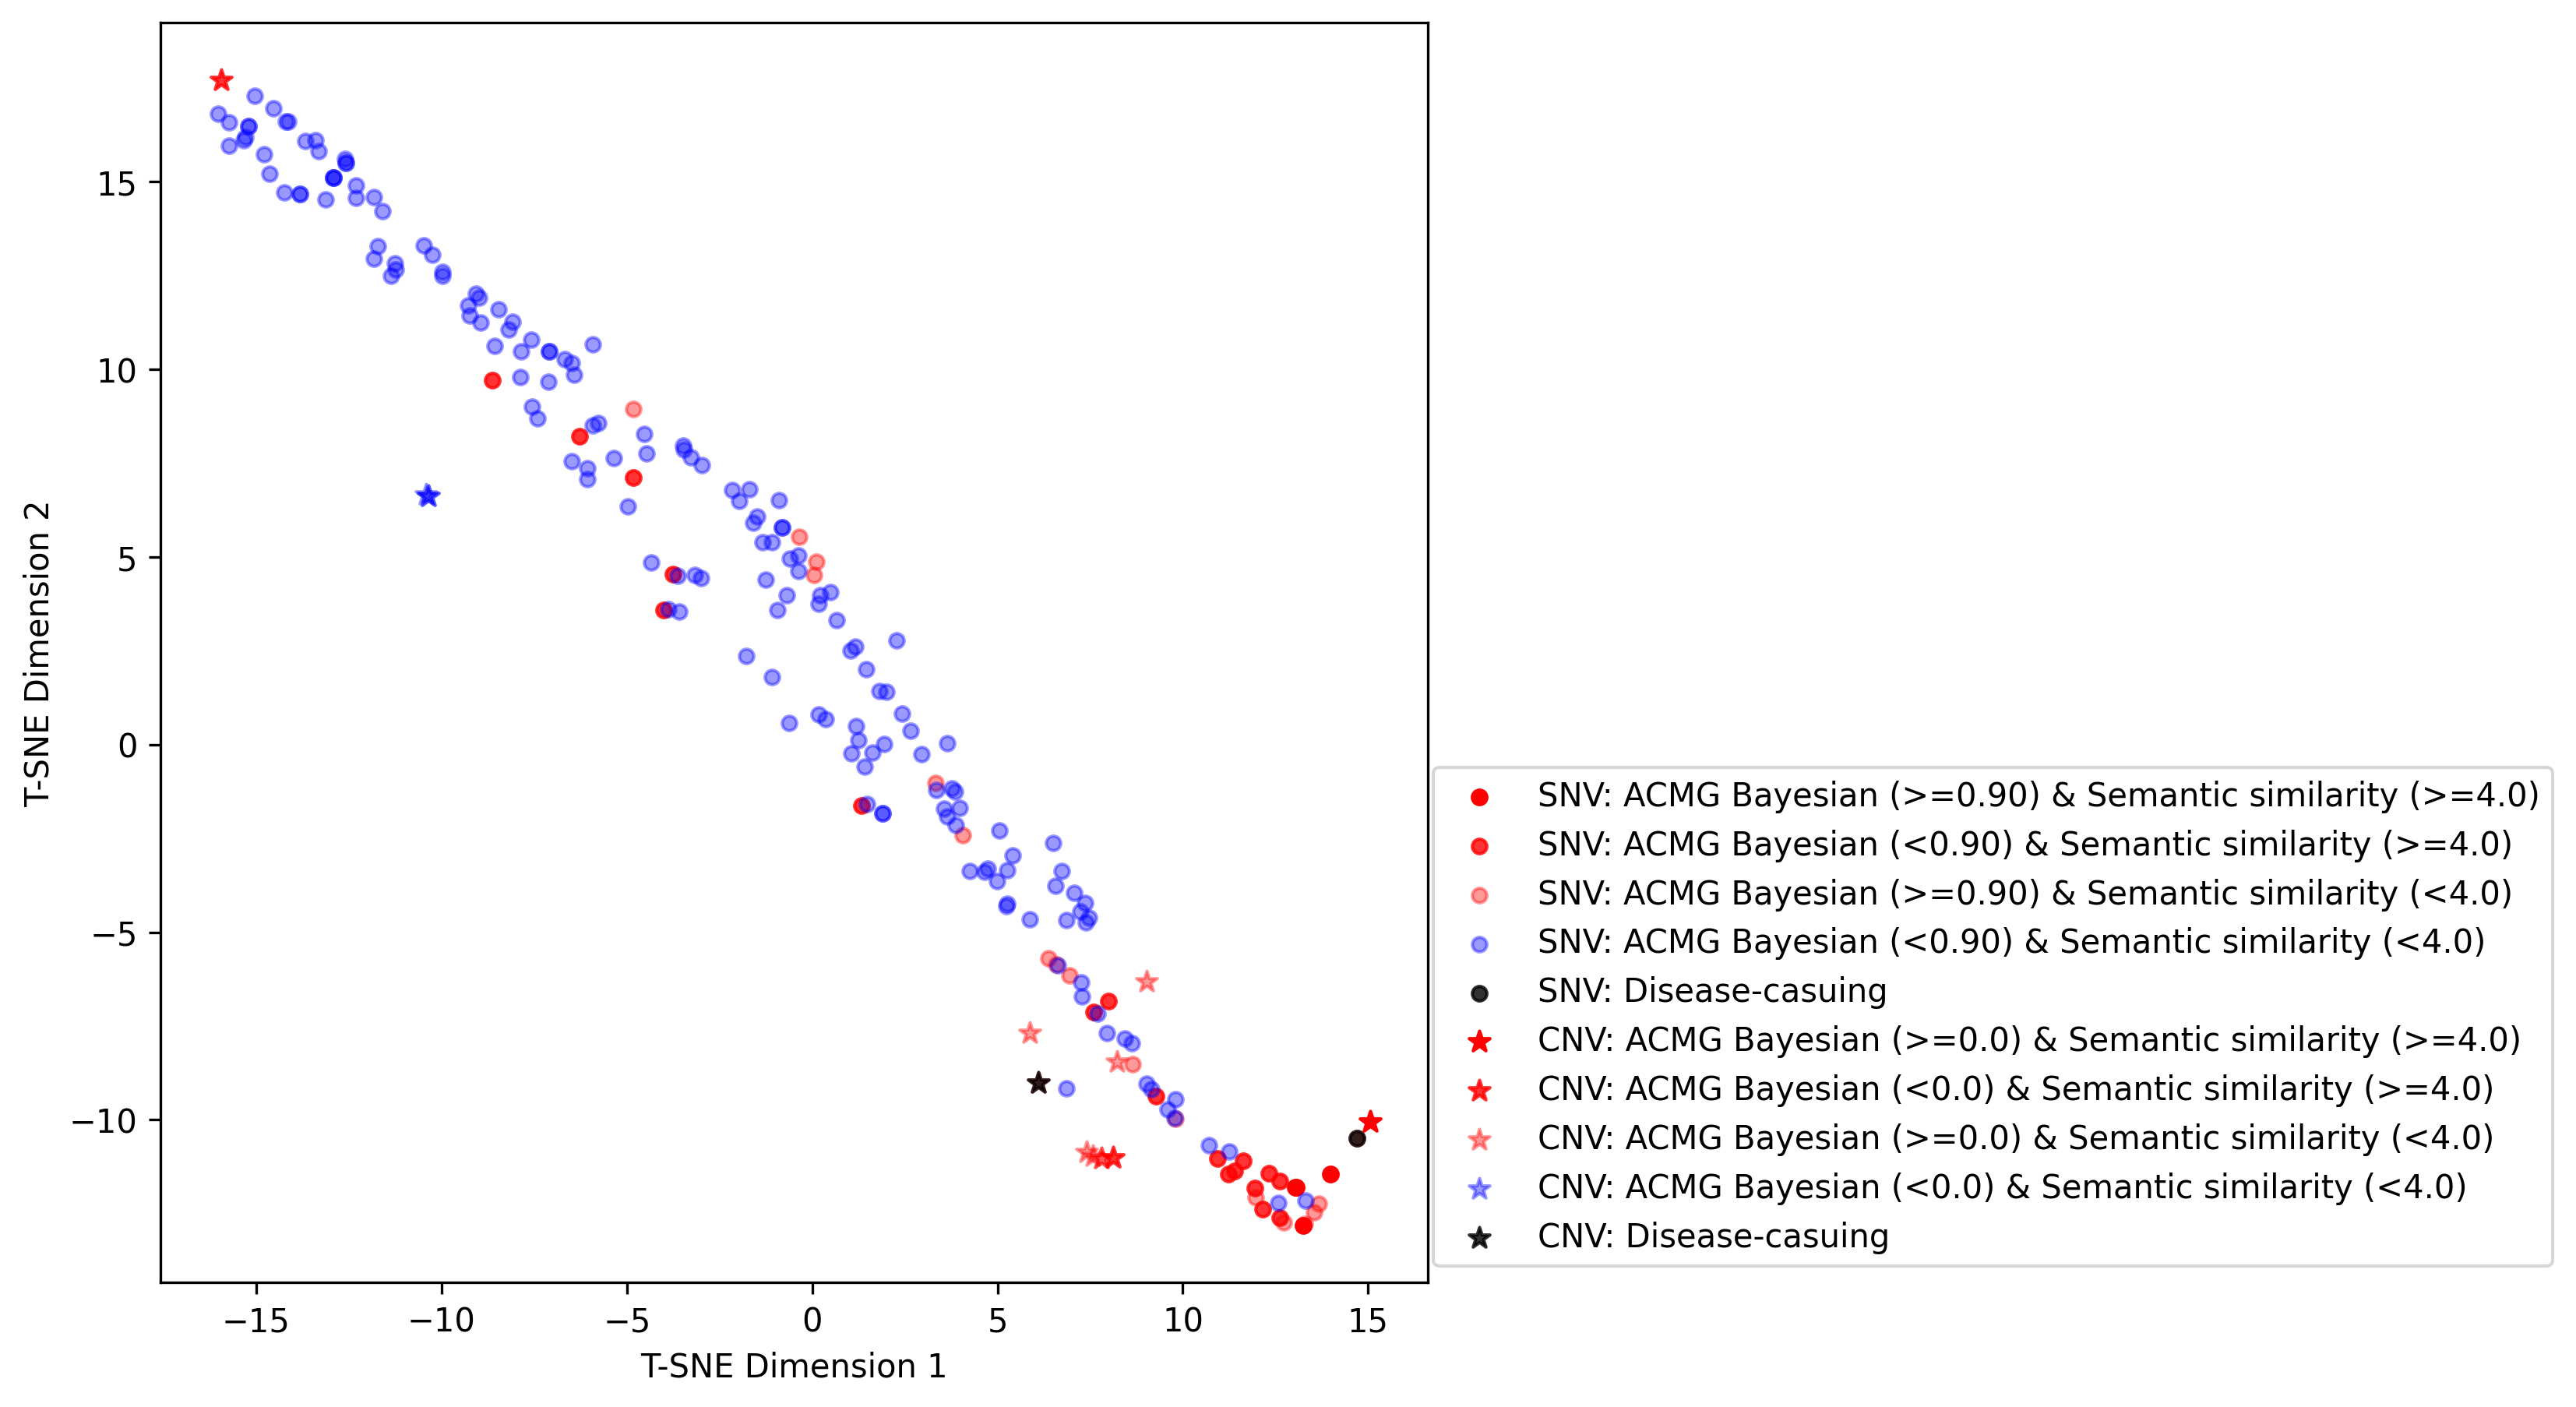

In [13]:
import numpy as np
from matplotlib import pyplot as plt
n_snv = len(test_dataset.patient_datasets[sample_idx].snv_data.x)

bayesian_array = test_dataset.patient_datasets[sample_idx].snv_data.x[:, 0]
symptom_array = test_dataset.patient_datasets[sample_idx].snv_data.x[:, 1]
label_array = test_dataset.patient_datasets[sample_idx].snv_data.y
snv_emb = snv_cnv_embedded[:n_snv]

class1 = np.where((bayesian_array >= 0.90) & (symptom_array >= 4.0))[0]
class2 = np.where((bayesian_array < 0.90) & (symptom_array >= 4.0))[0]
class3 = np.where((bayesian_array >= 0.90) & (symptom_array < 4.0))[0]
class4 = np.where((bayesian_array < 0.90) & (symptom_array < 4.0))[0]

fig, axes = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

axes.scatter(snv_emb[class1, 0], snv_emb[class1, 1], marker='o', color='red', label="SNV: ACMG Bayesian (>=0.90) & Semantic similarity (>=4.0)", alpha=1.0, s=20)
axes.scatter(snv_emb[class2, 0], snv_emb[class2, 1], marker='o', color='red', label="SNV: ACMG Bayesian (<0.90) & Semantic similarity (>=4.0)", alpha=0.8, s=20)
axes.scatter(snv_emb[class3, 0], snv_emb[class3, 1], marker='o', color='red', label="SNV: ACMG Bayesian (>=0.90) & Semantic similarity (<4.0)", alpha=0.4, s=20)
axes.scatter(snv_emb[class4, 0], snv_emb[class4, 1], marker='o', color='blue', label="SNV: ACMG Bayesian (<0.90) & Semantic similarity (<4.0)", alpha=0.4, s=20)
axes.scatter(snv_emb[np.where(label_array), 0], snv_emb[np.where(label_array), 1], marker='o', color='black', label="Disease-casuing", alpha=0.8 , s=20)

bayesian_array = test_dataset.patient_datasets[sample_idx].cnv_data.x[:, 0]
symptom_array = test_dataset.patient_datasets[sample_idx].cnv_data.x[:, 1]
label_array = test_dataset.patient_datasets[sample_idx].cnv_data.y
cnv_emb = snv_cnv_embedded[n_snv:]
class1 = np.where((bayesian_array >= 0) & (symptom_array >= 4.0))[0]
class2 = np.where((bayesian_array < 0) & (symptom_array >= 4.0))[0]
class3 = np.where((bayesian_array >= 0) & (symptom_array < 4.0))[0]
class4 = np.where((bayesian_array < 0) & (symptom_array < 4.0))[0]

axes.scatter(cnv_emb[class1, 0], cnv_emb[class1, 1], marker='*', color='red', label="CNV: ACMG Bayesian (>=0) & Semantic similarity (>=3.0)", alpha=1.0, s=45)
axes.scatter(cnv_emb[class2, 0], cnv_emb[class2, 1], marker='*', color='red', label="CNV: ACMG Bayesian (<0) & Semantic similarity (>=3.0)", alpha=0.8, s=45)
axes.scatter(cnv_emb[class3, 0], cnv_emb[class3, 1], marker='*', color='red', label="CNV: ACMG Bayesian (>=0) & Semantic similarity (<4.0)", alpha=0.4, s=45)
axes.scatter(cnv_emb[class4, 0], cnv_emb[class4, 1], marker='*', color='blue', label="CNV: ACMG Bayesian (<0) & Semantic similarity (<4.0)", alpha=0.4, s=45)
axes.scatter(cnv_emb[np.where(label_array), 0], cnv_emb[np.where(label_array), 1], marker='*', color='black', label="Disease-casuing", alpha=0.8, s=45)

legend_order = [
    "SNV: ACMG Bayesian (>=0.90) & Semantic similarity (>=4.0)",
    "SNV: ACMG Bayesian (<0.90) & Semantic similarity (>=4.0)",
    "SNV: ACMG Bayesian (>=0.90) & Semantic similarity (<4.0)",
    "SNV: ACMG Bayesian (<0.90) & Semantic similarity (<4.0)",
    "SNV: Disease-casuing",
    "CNV: ACMG Bayesian (>=0.0) & Semantic similarity (>=4.0)",
    "CNV: ACMG Bayesian (<0.0) & Semantic similarity (>=4.0)",
    "CNV: ACMG Bayesian (>=0.0) & Semantic similarity (<4.0)",
    "CNV: ACMG Bayesian (<0.0) & Semantic similarity (<4.0)",
    "CNV: Disease-casuing",
]

axes.legend(legend_order, loc="lower right", bbox_to_anchor=(1.9, 0))
axes.set_xlabel("T-SNE Dimension 1")
axes.set_ylabel("T-SNE Dimension 2")

plt.savefig(os.path.join(FIGURE_DIR, f"{patient_data.sample_id}.manifold.png"), bbox_inches='tight')